In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importation des bibliothèques nécessaires

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import os
import cv2 
import csv
import math
import zipfile
import time
import json
import operator

### Chargement de la base de données d'images depuis mon Google Drive

In [ ]:
files = 'GHIM' # chemin vers la base d'images

if not os.path.exists('/content/' + files):

    with zipfile.ZipFile('/content/drive/MyDrive/MIR/ghim.zip', 'r') as zip_ref:
      
        print('Chargement de la base de données GHIM 20...\n\n')
        zip_ref.extractall('/content')

    os.rename('GHIM-20库', files)

    print('Base de données GHIM 20 chargée ! ')
    print (len([name for name in os.listdir(files) if os.path.isfile(os.path.join(files, name))]), 'fichiers chargés')

else:

    print('Base de données GHIM 20 déjà chargée ! ')
    print (len([name for name in os.listdir(files) if os.path.isfile(os.path.join(files, name))]), 'fichiers chargés')


Chargement de la base de données GHIM 20...


Base de données GHIM 20 chargée ! 
10001 fichiers chargés


### Chargement de l'index selon le descripteur depuis mon Google Drive

In [ ]:
def getFeatures(fileJson):

    with open('/content/drive/MyDrive/MIR/Features_train/'+fileJson, 'r') as json_file:

          data = json.load(json_file)
          features = []
          index = data['index']
          nameDatabase = index['nameDatabase']
          descripteur = index['Descripteur']
          exec_time = index['exec_time']
          n_Images = index['n_Images']

          print(f'Index de la database d\'images {nameDatabase} fait par le descripteur {descripteur} va être chargé...\nNombres d\'images indexées de cette database : {n_Images} en {exec_time} sec.')

          for item in data['image']:

              nameImg = item['data']
              d1 = item['desc']  #Cela renvoie un string que l'on doit de nouveau serialisé en json pour pouvoir extraire le numpy array
              d2 = json.loads(d1)
              desc = np.asarray(d2['array'])

              features.append((nameImg,desc))
          print('Index chargé !')

          return features

### Fonction de combinaison de descripteur

In [ ]:
def combineDesc(feature1, feature2, n_Images = 10000):
    combined_Features = []
    for i in range(n_Images):
        tmp = np.concatenate((feature1[i][1], feature2[i][1]), axis=None)
        combined_Features.append((feature1[i][0],tmp))

    return combined_Features

### Fonctions de calcul de similarité

In [ ]:
def euclidean(l1, l2):
    n = min(len(l1), len(l2))
    return np.sqrt(np.sum((l1[:n] - l2[:n])**2))

def chiSquareDistance(l1, l2):
    n = min(len(l1), len(l2))
    return np.sum((l1[:n] - l2[:n])**2 / l2[:n])

def bhatta(l1, l2):
    n = min(len(l1), len(l2))
    N_1, N_2 = np.sum(l1[:n])/n, np.sum(l2[:n])/n
    score = np.sum(np.sqrt(l1[:n] * l2[:n]))
    num = round(score, 2)
    den = round(math.sqrt(N_1*N_2*n*n), 2)
    return math.sqrt( 1 - num / den )

### Fonctions permettant d'obtenir une liste triée selon les plus petits distances avec l'image d'input grâce à un index

In [ ]:
def getkVoisins(func, lfeatures, test, k): 
    ldistances = []
    for i in range(len(lfeatures)):
        # Concernant les descripteurs SIFT et ORB, il se peut que l'array desc soit None donc le numpy array contient juste -1, on ignore tout simplement la feature et l'image
        if len(lfeatures[i][1]) > 1:
            dist = func(test[1], lfeatures[i][1]) 
            ldistances.append((lfeatures[i][0], lfeatures[i][1], dist))

    ldistances.sort(key=operator.itemgetter(2))
    lvoisins = []
    for i in range(k):
        lvoisins.append(ldistances[i])
    return lvoisins

### Fonction permettant d'obtenir le top K d'une liste d'images requêtes selon la fonction de calcul de similarité et le ou les descripteur(s)

In [ ]:
import warnings

def getTop(listInputImg, funcSim, sortie, fileJson, fileJson2 = None):

    if fileJson2 == None:
      features = getFeatures(fileJson)
      print(f'Get Top {sortie} with {fileJson}')

    else:
      feature1 = getFeatures(fileJson)
      feature2 = getFeatures(fileJson2)

      features = combineDesc(feature1, feature2)
      print(f'Get Top {sortie} with {fileJson} and {fileJson2}')
    
    noms_Voisins = []

    for item in listInputImg:

        imgRequest = [img for img in features if img[0] == item + '.jpg'][0]
        warnings.filterwarnings('ignore')
        voisins = getkVoisins(funcSim, features, imgRequest, sortie)

        nom_image_plus_proches = [] 

        for k in range(sortie): 
            nom_image_plus_proches.append(voisins[k][0])
        
        noms_Voisins.append(nom_image_plus_proches)

    return noms_Voisins

### Fonction permettant de retourner le rappel, la précision et l'average precision selon l'image input et le top K généré par l'index

In [ ]:
def getRP(imgInput, voisins, sortie):
    classInput = imgInput[0]

    print(f'Classe de l\'image input : {classInput}')

    classVoisins = []
    for item in voisins:
        classVoisins.append(item[0])

    RP = []
    nbreImagesIn1Class = 500

    for i in range(sortie):

        P = 0
        R = 0
        for j in range(0,i+1):
            if classVoisins[j] == classInput:
                P += 1
                R += 1
        P /= i+1
        R /= nbreImagesIn1Class
        RP.append((R,P))

    AP = sum([item[1] for item in RP])/sortie

    return RP, RP[-1], AP



### Fonction d'affichage des valeurs de rappel, précision et average d'une liste d'images input 

In [ ]:
def showRP(listImg, voisins, top):
    print('\nTop ', top)
    globalAPs = []
    APs = []

    for i in range(len(listImg)):
        print('\nImage ', i+1 ,' : ', listImg[i])
        RPs, RP, AP = getRP(listImg[i], voisins[i], top)
        print('R : ', RP[0])
        print('P : ', RP[1])
        print('AP : ', AP)
        globalAPs.append(AP)

    

    MAP = sum([item for item in globalAPs])/len(listImg)
    print(f'\nMean average Precision for all class in Top {top} => MAP = {MAP}\n')


In [ ]:
listImg = ['0_201','0_79','0_458','2_1307','2_1029','2_1207','3_1842','3_1560','3_1903','5_2506','5_2810','5_2948','7_3501','7_3744','7_3998']


descJson = 'VGG16.json'
desc2Json = None # si pas de 2ème descripteur, faire desc2Json = None
dist = euclidean

voisins50 = getTop(listImg, dist, 50, descJson, desc2Json)
showRP(listImg, voisins50, 50)

voisins100 = getTop(listImg, dist, 100, descJson, desc2Json)
showRP(listImg, voisins100, 100)

voisins500 = getTop(listImg, dist, 500, descJson, desc2Json)
showRP(listImg, voisins500, 500)
    

Index de la database d'images GHIM fait par le descripteur VGG16 va être chargé...
Nombres d'images indexées de cette database : 10000 en 482.44247674942017 sec.
Index chargé !
Get Top 50 with VGG16.json

Top  50

Image  1  :  0_201
Classe de l'image input : 0
R :  0.1
P :  1.0
AP :  1.0

Image  2  :  0_79
Classe de l'image input : 0
R :  0.1
P :  1.0
AP :  1.0

Image  3  :  0_458
Classe de l'image input : 0
R :  0.092
P :  0.92
AP :  0.97588142709934

Image  4  :  2_1307
Classe de l'image input : 2
R :  0.062
P :  0.62
AP :  0.7713521789157247

Image  5  :  2_1029
Classe de l'image input : 2
R :  0.056
P :  0.56
AP :  0.6643214488518807

Image  6  :  2_1207
Classe de l'image input : 2
R :  0.084
P :  0.84
AP :  0.9063390473997879

Image  7  :  3_1842
Classe de l'image input : 3
R :  0.1
P :  1.0
AP :  1.0

Image  8  :  3_1560
Classe de l'image input : 3
R :  0.1
P :  1.0
AP :  1.0

Image  9  :  3_1903
Classe de l'image input : 3
R :  0.082
P :  0.82
AP :  0.6865834183083855

Image  10

In [ ]:
import warnings

#Top pour une seule image + affichage
def getTopForAnImage(inputImg, funcSim, sortie, fileJson, fileJson2 = None):

    if fileJson2 == None:
        features = getFeatures(fileJson)

        print(f'Get Top {sortie} with {fileJson}')

    else:
        feature1 = getFeatures(fileJson)
        feature2 = getFeatures(fileJson2)

        features = combineDesc(feature1, feature2)
        print(f'Get Top {sortie} with {fileJson} and {fileJson2}')

    imgRequest = [img for img in features if img[0] == inputImg + '.jpg'][0]
    warnings.filterwarnings('ignore')
    voisins = getkVoisins(funcSim, features, imgRequest, sortie)

    nom_image_plus_proches = [] 

    for k in range(sortie): 
        nom_image_plus_proches.append(voisins[k][0])

    plt.figure(figsize=(5, 5))
    plt.imshow(imread(files+"/"+imgRequest[0]), cmap='gray', interpolation='none') 
    plt.title("Image requête")
    nom_image_requete=os.path.splitext(os.path.basename(files+"/"+imgRequest[0]))[0] 
    print(nom_image_requete + '.jpg')

    plt.figure(figsize=(25, 25)) 
    plt.subplots_adjust(hspace=0.2, wspace=0.2)

    for j in range(sortie):
        plt.subplot(sortie/4,sortie/5,j+1) 
        plt.imshow(imread(files+"/"+nom_image_plus_proches[j]), cmap='gray',interpolation='none')

        title = "Image proche n°"+str(j)
        plt.title(title)

    return imgRequest[0], nom_image_plus_proches, sortie

Index de la database d'images GHIM fait par le descripteur VGG16 va être chargé...
Nombres d'images indexées de cette database : 10000 en 482.44247674942017 sec.
Index chargé !
Get Top 50 with VGG16.json
0_201.jpg

Image :  0_201.jpg
Classe de l'image input : 0
R :  0.1
P :  1.0
AP :  1.0


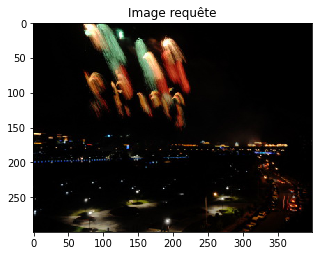

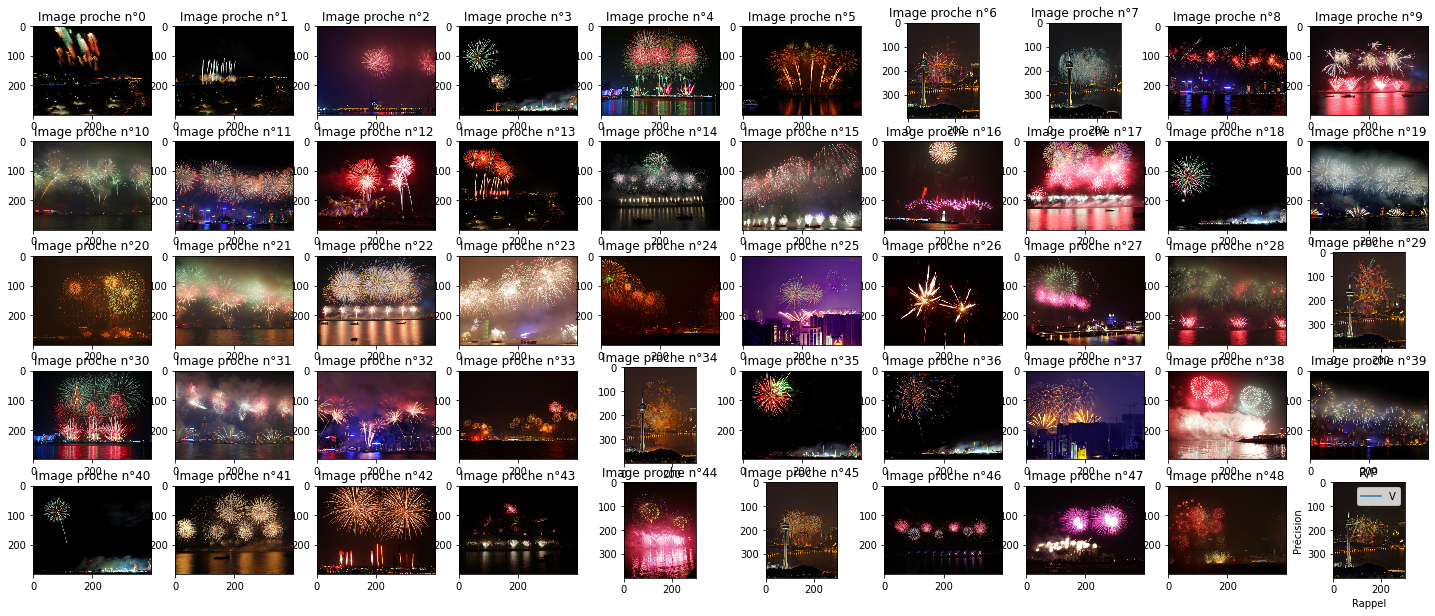

In [ ]:
imgInput, voisins, sortie = getTopForAnImage('0_201', euclidean, 50, 'VGG16.json')
print('\nImage : ', imgInput)
RPs, RP, AP = getRP(imgInput, voisins, sortie)
print('R : ', RP[0])
print('P : ', RP[1])
print('AP : ', AP)

In [ ]:
getFeatures('HistoColor.json')
getFeatures('SIFT.json')
getFeatures('ORB.json')
getFeatures('VGG16.json')
getFeatures('VGG19.json')
getFeatures('inceptionV3.json')
#getFeatures('LBP.json')
getFeatures('Resnet50.json')
getFeatures('')